In [1]:
import mxnet as mx
from os.path import join
from mxnet import nd
import numpy as np
from sklearn.model_selection import train_test_split
import pdb
import os
import gluonbook as gbk
import matplotlib.pyplot as plt
##from dataset_loader import DatasetLoader

### Define Constants:

In [2]:
# CASC_PATH = './haarcascade_files/haarcascade_frontalface_default.xml'
SIZE_FACE = 48
EMOTIONS = ['angry', 'disgusted', 'fearful',
            'happy', 'sad', 'surprised', 'neutral']
SAVE_DIRECTORY = './DATASET/FER2013/'
SAVE_MODEL_FILENAME = 'My_final_model'
IMAGES_FILENAME = 'data_images.npy'
LABELS_FILENAME = 'data_labels.npy'
CTX = mx.gpu(3)
MODEL_PREFIX = 'models/My_FER_model'
CKPT_DIR = 'models/'

### Step 1: Model Setup

In [3]:
class EmotionNet:
    def __init__(self, num_classes):
        self.num_cls = num_classes
    def build_network(self):
        data = mx.sym.Variable('data')
        conv_1 = mx.symbol.Convolution(data=data, kernel=(5,5), num_filter=64)
        relu_1 = mx.symbol.Activation(data=conv_1, act_type='relu')
        maxpool_1 = mx.symbol.Pooling(data=relu_1,kernel=(3,3), stride=(2,2), pool_type='max')
        
        conv_2 = mx.symbol.Convolution(data=maxpool_1, kernel=(5,5), num_filter=64)
        relu_2 = mx.symbol.Activation(data=conv_2, act_type='relu')
        maxpool_2 = mx.symbol.Pooling(data=relu_2, kernel=(3,3), stride=(2,2), pool_type='max')
        
        conv_3 = mx.symbol.Convolution(data=maxpool_2, kernel=(4,4), num_filter=128)
        drop_3 = mx.symbol.Dropout(data=conv_3, p=0.3)
        
        fc_1 = mx.symbol.FullyConnected(data=drop_3, num_hidden=1024)
        relu_3 = mx.symbol.Activation(data=fc_1, act_type='relu')
        fc_2 = mx.symbol.FullyConnected(data=relu_3, num_hidden=self.num_cls)
        softmax = mx.symbol.SoftmaxOutput(data=fc_2, name='softmax')
        
        return softmax

In [4]:
e = EmotionNet(num_classes=len(EMOTIONS))
e_out = e.build_network()

#### Check network design

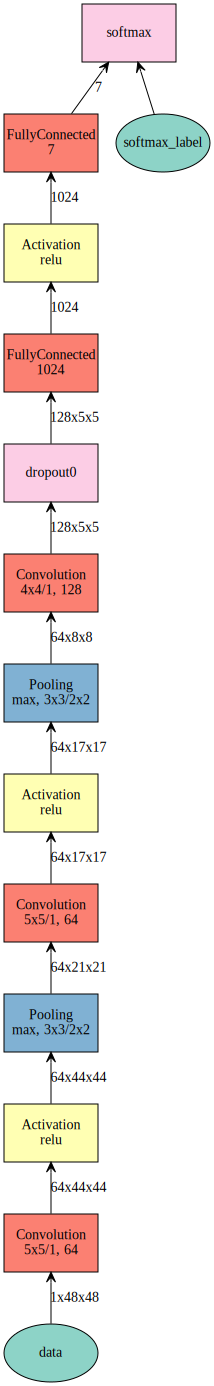

In [5]:
mx.viz.plot_network(e_out,shape={"data": (128,1,48,48)})

### Step2: Load Dataset

In [6]:
images = np.load(join(SAVE_DIRECTORY, IMAGES_FILENAME))
images = np.expand_dims(images, axis=1)
labels = np.load(join(SAVE_DIRECTORY, LABELS_FILENAME))
# 注意：使用mxnet module API训练多分类任务时，最好不要使用one-hot标签
labels_tight = np.argmax(labels,axis=1)
X_train,X_test,y_train,y_test = train_test_split(images, labels_tight, test_size=0.1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((12616, 1, 48, 48), (1402, 1, 48, 48), (12616,), (1402,))


In [7]:
train_iter = mx.io.NDArrayIter(X_train, y_train, 32, True, last_batch_handle='roll_over',)
                             #data_name='X_train', label_name='y_train')
val_iter = mx.io.NDArrayIter(X_test, y_test, 32, True, last_batch_handle='roll_over',)
                             #data_name='X_val', label_name='y_val')

#### Check dataloader

* Define a helper function to sample dataset and visualize

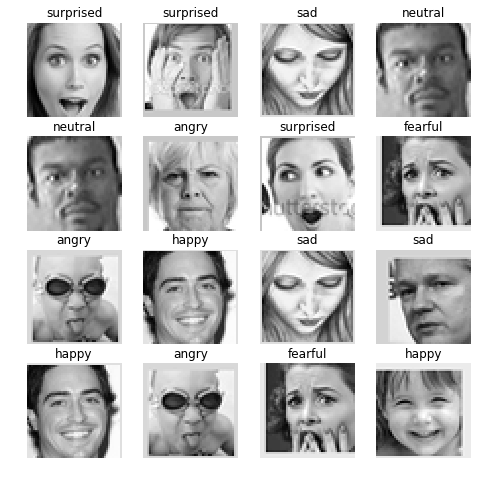

In [8]:
def viz_dataset(imgs,lbs, nn=9):
    '''n为2^2, 3^2, 4^2等'''
    rr = np.sqrt(nn)
    imgs = imgs.asnumpy().squeeze()
    lbs = lbs.asnumpy()
    for i in range(nn):
        sample_ind = np.random.choice(range(len(imgs)), nn, replace=True)
        #pdb.set_trace()
        plt.subplot(rr,rr,i+1)
        plt.imshow(imgs[sample_ind[i]],'gray')
        plt.axis('off')
        plt.title(EMOTIONS[int(lbs[sample_ind[i]])])
batch = val_iter.next()
imgs,lbs = batch.data[0], batch.label[0]
fig = plt.figure(figsize=(8,8))
viz_dataset(imgs, lbs, 16)

### Step3: Training Loop

In [ ]:
import logging
def train(num_epoch=10000, learning_rate=0.01):
    '''
    Constants: MODEL_PREFIX, CKPT_DIR, CTX

    '''
    num_epoch = num_epoch
    check_point = mx.callback.do_checkpoint(MODEL_PREFIX, 100)
    op_params = {'learning_rate':learning_rate,
                 'lr_scheduler': mx.lr_scheduler.FactorScheduler(step=500, factor=0.98),
                 'wd':0.0005
                }
    logging.getLogger().setLevel(logging.DEBUG)

    params_list = os.listdir(CKPT_DIR)
    if params_list is not None:
        params_list = [x for x in params_list if x.endswith('.params')]
        params_list = sorted(params_list, key = lambda x: x.split('-')[-1].split('.')[0], reverse=True)
        begin_epoch = int(params_list[0].split('-')[-1].split('.')[0])
        print('loading checkpoints: {0}'.format(MODEL_PREFIX+'_'+str(begin_epoch)))
        sym, arg_params, aux_params = mx.model.load_checkpoint(MODEL_PREFIX, begin_epoch)
        mod = mx.mod.Module(symbol=sym,
                            data_names=['data'],
                            label_names=['softmax_label'],
                            context=CTX)
        mod.fit(train_data=train_iter,
            eval_data=val_iter,
            optimizer='sgd',
            eval_metric=['acc',mx.metric.CrossEntropy()],
            optimizer_params=op_params,
            arg_params=arg_params,
            epoch_end_callback = check_point,
            begin_epoch=begin_epoch,
            num_epoch=num_epoch,
            initializer=mx.initializer.Xavier()
             )

    else:  # training from scratch
        begin_epoch=1
        mod = mx.mod.Module(symbol=e_out,
                        data_names=['data'],
                        label_names=['softmax_label'],
                        context=CTX)
        mod.fit(train_data=train_iter,
            eval_data=val_iter,
            optimizer='sgd',
            eval_metric=['acc',mx.metric.CrossEntropy()],
            optimizer_params=op_params,
            epoch_end_callback = check_point,
            begin_epoch=begin_epoch,
            num_epoch=num_epoch,
            initializer=mx.initializer.Xavier()
             )
train()

### Step4: Model Evaluation

####  见eval.py(单幅图像检测)   和   cam_demo.py（camera）

---

# 9月25日更新

* 使用新数据集：RAF-DB数据集。  
特点：网络收集的数据集，质量中等，彩色；数据量15000+；  
* 标注情况：有原始图像/对齐图像 两种数据集可供使用  
  
  
* 其中对齐图像可以直接使用。原始图像具有多种标注信息：①分层抽样的测试集②每张图像单一表情标签③人脸bbox

In [24]:
import os
import sys
import numpy as np
from sh import cp
from tqdm import tqdm
import mxnet as mx
import gluonbook as gbk
import matplotlib.pyplot as plt
from mxnet import nd
from collections import namedtuple
import logging

## Step 1：数据集处理

* 为了将数据集压成rec，需要先根据不同类别分成不同文件夹。由于数据集已经划分出了测试样本，先把测试集单独放到一个文件夹

In [11]:
EMOTION_LIST = ['Anger','Disgust','Fear','Happiness','Neutral','Sadness','Surprise']

为了避免重复执行shell命令，将数据处理过程中已执行过的命令写成markdown格式

``` python
cd ..
! sed -i 's/.jpg/_aligned.jpg/g' raf.json  
# 划分出测试文件夹和训练文件夹
! mkdir RAF/TestSet/ && ls RAF/ | grep test | xargs -i mv RAF/{} RAF/TestSet  
mkdir RAF/TrainSet/ && ls RAF/ | grep train | xargs -i mv RAF/{} RAF/TrainSet  
[os.makedirs('RAF/TestSet/'+ x) for x in EMOTION_LIST]  
[os.makedirs('RAF/TrainSet/'+ x) for x in EMOTION_LIST]  
with open ('raf.json','r') as f:  
    content = f.readlines()  
test_json = [json.loads(x) for x in content if 'test' in x ]  
train_json = [json.loads(x) for x in content if 'train' in x]  

```

* 使用下面这种交互写法，需要将变量从python传给shell，处理速度很慢，不适合处理太大规模的数据集

```python  
#按json文件中的类别信息将数据集划分到七个子文件夹，每个文件夹名称为一种表情名称
for i in range(len(test_json)): 
    !cp RAF/TestSet/{test_json[i].keys()[0]}  RAF/TestSet/{EMOTION_LIST[test_json[i].values()[0][-1] - 1]}
```

* 使用python中的sh工具箱处理起来快得多

```python
from sh import cp
for i in tqdm(range(len(train_json))):
    cp('RAF/TrainSet/'+train_json[i].keys()[0], 'RAF/TrainSet/' + EMOTION_LIST[train_json[i].values()[0][-1] - 1])
```

In [88]:
#! rm RAF/TestSet/*.jpg
#! rm RAF/TrainSet/*.jpg
!ls RAF/TrainSet/*/ | wc -l

12284


* **将数据集转换为rec格式**
```python
data_dir = 'RAF/TrainSet/'  
prefix = 'data'  
#os.mkdir('RAF/rec_dataset')
! python RAF/im2rec.py --recursive --train-ratio 0.9 --list {data_dir+prefix} {data_dir}  
! python RAF/im2rec.py --num-thread 8 {data_dir} {data_dir}  
! mv {data_dir+prefix}* RAF/rec_dataset
```

In [51]:
data_dir = 'RAF/TrainSet/'  
prefix = 'data'  
#os.mkdir('RAF/rec_dataset')
! python RAF/im2rec.py --recursive --train-ratio 0.9 --list {data_dir+prefix} {data_dir}  
! python RAF/im2rec.py --num-thread 8 {data_dir} {data_dir}  
! mv {data_dir+prefix}* RAF/rec_dataset

Anger 0
Disgust 1
Fear 2
Happiness 3
Neutral 4
Sadness 5
Surprise 6
Creating .rec file from /home/users/chengyuan.yang/Pycharm_Project/FER_Project/My_Project/DATASET/RAF/TrainSet/data_val.lst in /home/users/chengyuan.yang/Pycharm_Project/FER_Project/My_Project/DATASET/RAF/TrainSet
time: 0.0028281211853  count: 0
time: 0.0862629413605  count: 1000
Creating .rec file from /home/users/chengyuan.yang/Pycharm_Project/FER_Project/My_Project/DATASET/RAF/TrainSet/data_train.lst in /home/users/chengyuan.yang/Pycharm_Project/FER_Project/My_Project/DATASET/RAF/TrainSet
time: 0.00192809104919  count: 0
time: 0.085638999939  count: 1000
time: 0.0679578781128  count: 2000
time: 0.06760597229  count: 3000
time: 0.0703411102295  count: 4000
time: 0.0681610107422  count: 5000
time: 0.0693328380585  count: 6000
time: 0.0673880577087  count: 7000
time: 0.0667490959167  count: 8000
time: 0.0666079521179  count: 9000
time: 0.0640981197357  count: 10000
time: 0.0646197795868  count: 11000


*问题：im2rec生成lst文件时怎么控制标签的顺序？（比如suprise,happy各自应该映射至0-6哪一个标签）*

## Check rec dataset

In [91]:
def get_iterators(resize_shape=48, data_dir='DATASET/RAF/rec_dataset/', batch_size=64, channel=3):
        train_iter = mx.io.ImageRecordIter( 
        path_imgrec=data_dir + 'data_train.rec', 
        data_shape=(channel, resize_shape, resize_shape), 
        batch_size=batch_size,
        #fill_value=0, 
        #mean_r=84,
        # mean_r=84, 
        # mean_g=84, 
        # mean_b=84,
        resize = resize_shape,    #must add resize param otherwise will be cropped                 
        rand_mirror=True,                 
        brightness =0.125,                 
        contrast =0.125,                 
        pca_noise = 0.125,  
        scale = 1.0/255.0
        #max_rotate_angle=5,     
        )         
        val_iter = mx.io.ImageRecordIter(                 
        path_imgrec=data_dir + 'data_val.rec',                 
        data_shape=(channel, resize_shape, resize_shape),                 
        resize = resize_shape,                 
        batch_size=batch_size, 
        scale = 1.0/255.0,
            
        # mean_r=84,                    
        # mean_g=84,                     
        # mean_b=84,                 
        )         
        return train_iter, val_iter
train_iter, val_iter = get_iterators()

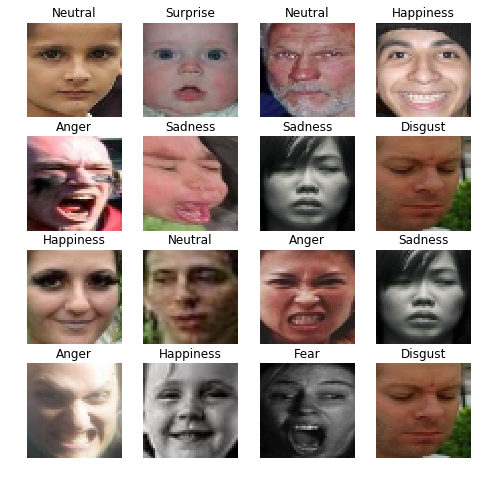

In [94]:
def viz_dataset(imgs,lbs, nn=9):
    '''n为2^2, 3^2, 4^2等'''
    rr = np.sqrt(nn)
    imgs = imgs.asnumpy().squeeze()
    lbs = lbs.asnumpy()
    for i in range(nn):
        sample_ind = np.random.choice(range(len(imgs)), nn, replace=True)
        #pdb.set_trace()
        plt.subplot(rr,rr,i+1)
        plt.imshow(imgs[sample_ind[i]],'gray')
        plt.axis('off')
        plt.title(EMOTION_LIST[int(lbs[sample_ind[i]])])
        
train_batch = train_iter.next()
x_train, y_train = train_batch.data[0],train_batch.label[0]
fig = plt.figure(figsize=(8,8))
viz_dataset(x_train.transpose((0,2,3,1)), y_train, 16)

## Train Loop

In [18]:
MODEL_PREFIX = 'models/Model_RAF_'
CKPT_DIR = 'models/'
CTX = [mx.gpu(2), mx.gpu(3)]

In [102]:
def train(num_epoch=10000, learning_rate=0.005, from_scratch=False):
    '''
    Constants: MODEL_PREFIX, CKPT_DIR, CTX

    '''
    num_epoch = num_epoch
    check_point = mx.callback.do_checkpoint(MODEL_PREFIX, 100)
    op_params = {'learning_rate':learning_rate,
                 'lr_scheduler': mx.lr_scheduler.FactorScheduler(step=10000, factor=0.98),
                 'wd':0.0005
                }
    logging.getLogger().setLevel(logging.DEBUG)

    params_list = os.listdir(CKPT_DIR)
    if (params_list is not None) & (from_scratch is False):
        params_list = [x for x in params_list if x.endswith('.params')]
        params_list = sorted(params_list, key = lambda x: x.split('-')[-1].split('.')[0], reverse=True)
        begin_epoch = int(params_list[0].split('-')[-1].split('.')[0])
        print('loading checkpoints: {0}'.format(MODEL_PREFIX+'_'+str(begin_epoch)))
        sym, arg_params, aux_params = mx.model.load_checkpoint(MODEL_PREFIX, begin_epoch)
        mod = mx.mod.Module(symbol=sym,
                            data_names=['data'],
                            label_names=['softmax_label'],
                            context=CTX)
        mod.fit(train_data=train_iter,
            eval_data=val_iter,
            optimizer='sgd',
            eval_metric=['acc',mx.metric.CrossEntropy()],
            optimizer_params=op_params,
            arg_params=arg_params,
            epoch_end_callback = check_point,
            begin_epoch=begin_epoch,
            num_epoch=num_epoch,
            initializer=mx.initializer.Xavier()
             )

    else:  # training from scratch
        begin_epoch=1
        mod = mx.mod.Module(symbol=e_out,
                        data_names=['data'],
                        label_names=['softmax_label'],
                        context=CTX)
        mod.fit(train_data=train_iter,
            eval_data=val_iter,
            optimizer='sgd',
            eval_metric=['acc',mx.metric.CrossEntropy()],
            optimizer_params=op_params,
            epoch_end_callback = check_point,
            begin_epoch=begin_epoch,
            num_epoch=num_epoch,
            initializer=mx.initializer.Xavier()
             )

In [ ]:
e = EmotionNet(num_classes=len(EMOTION_LIST))
e_out = e.build_network()
train(from_scratch=True)

## Evaluation

In [111]:
def test_iterator(resize_shape=48, data_dir='DATASET/RAF/rec_dataset/', batch_size=1000, channel=3):
        test_iter = mx.io.ImageRecordIter(                 
        path_imgrec=data_dir + 'data_test.rec',                 
        data_shape=(channel, resize_shape, resize_shape),                 
        resize = resize_shape,                 
        batch_size=batch_size, 
        scale = 1.0/255.0,
            
        # mean_r=84,                    
        # mean_g=84,                     
        # mean_b=84,                 
        )         
        return test_iter

In [112]:
test_iter = test_iterator()

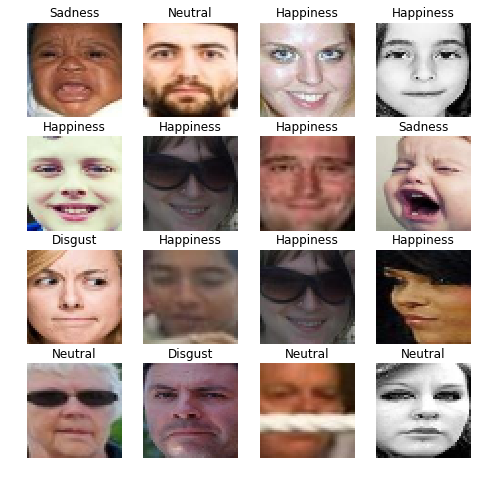

In [113]:
def viz_dataset(imgs,lbs, nn=9):
    '''n为2^2, 3^2, 4^2等'''
    rr = np.sqrt(nn)
    imgs = imgs.asnumpy().squeeze()
    lbs = lbs.asnumpy()
    for i in range(nn):
        sample_ind = np.random.choice(range(len(imgs)), nn, replace=True)
        #pdb.set_trace()
        plt.subplot(rr,rr,i+1)
        plt.imshow(imgs[sample_ind[i]],'gray')
        plt.axis('off')
        plt.title(EMOTION_LIST[int(lbs[sample_ind[i]])])
test_batch = test_iter.next()
x_test, y_test = test_batch.data[0],test_batch.label[0]
fig = plt.figure(figsize=(8,8))
viz_dataset(x_test.transpose((0,2,3,1)), y_test, 16)

In [114]:
def build_model(model_prefix, num_epoch):
    sym, arg_params, aux_params = mx.model.load_checkpoint(model_prefix, num_epoch)
    data = mx.sym.Variable(name='data')
    mod = mx.mod.Module(symbol=sym, context=mx.cpu(0), label_names=None)
    mod.bind(for_training=False, data_shapes=test_iter.provide_data,label_shapes=test_iter.provide_label)
    mod.set_params(arg_params, aux_params, allow_missing=True)
    Batch = namedtuple('Batch', ['data'])
    return mod, Batch
mod, Batch = build_model(MODEL_PREFIX,10000)

/home/users/chengyuan.yang/ENV/lib/python2.7/site-packages/mxnet/module/base_module.py:66: UserWarning: Data provided by label_shapes don't match names specified by label_names ([DataDesc[softmax_label,(1000L,),<type 'numpy.float32'>,NCHW]] vs. [])
  warnings.warn(msg)


In [115]:
mod.forward(test_batch)

In [116]:
prob = mod.get_outputs()[0].asnumpy()

In [118]:
np.mean(test_batch.label[0].asnumpy()==np.argmax(prob,axis=1))

0.779

In [ ]:
for i in range()

## 实验区

* 注意float型图像不能直接imshow

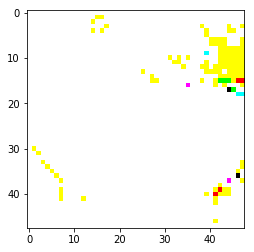

In [16]:
plt.imshow(x_train[1].asnumpy().transpose((1,2,0)))

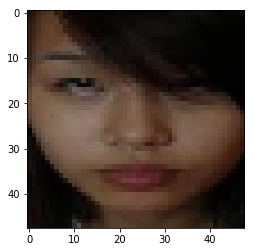

In [15]:
#注意：这里从dataiter读取出来的图像不知道为啥是float型的。不能直接进行imshow。需要转换成uint8或者将图像像素值归一化到0-1
#plt.imshow(np.uint8(x_val[4].asnumpy().transpose((1,2,0))))
plt.imshow(x_train[1].asnumpy().transpose((1,2,0))/255.)